In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 6)
%matplotlib inline

# Medical Insurance Cost: ОБЗОР
# Модель предсказания цены на медицинскую страховку
---
- **Цель**: предсказать стоимость медицинской страховки на основе демографических и медицинских факторов.
- **Тип задачи**: регрессия.
- **Метрики**: RMSE, MAE, R².

# 1. Первичный осмотр данных.

In [3]:
df = pd.read_csv('medical_insurance.csv')
display(df.head())
display(df.info())
print(f'Размер: {df.shape[0]} записей на {df.shape[1]} признаков.')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


None

Размер: 2772 записей на 7 признаков.


In [4]:
print(f'ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:')
display(df.describe())

ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:


,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
# Проверка на пустые ячейки
def fill_empty_data(df):
    # TODO: Функция для заполнения пустых ячеек.
    ...
    return df
    

if df.isna().any().any():
    print(f'Пустые записи:\n{df.info()}')
    df = fill_empty_data(df=df)
    print('Пустые ячейки заполнены.')
else:
    print('Нет пустых записей.')

print('_' * 45)

# Проверка на дупликаты
duplicated = df.duplicated().sum()

if duplicated:
    initial_len = df.shape[0]
    print(f'Найдено {duplicated} повторяющихся записей.')
    df = df.drop_duplicates().reset_index(drop=True)
    print(f'Дубликаты удалены; новый размер датасета: {initial_len} -> {df.shape[0]} строк.')
else:
    print('Нет повторяющихся запией.')

Нет пустых записей.
_____________________________________________
Найдено 1435 повторяющихся записей.
Дубликаты удалены; новый размер датасета: 2772 -> 1337 строк.


# 2. Разведочный анализ данных (EDA)

In [6]:
num_features = {
    'age': 'Возраст',
    'bmi': 'Индекс BMI',
    'children': 'Количество детей',
    'charges': 'Цена мед. страховки'
}

cat_features = {
    'sex': 'Пол',
    'smoker': 'Привычка курения',
    'region': 'Регион'
}

In [7]:
from scipy import *
from scipy.stats import *

# Доверительный интервал
def confidence_interval(feature, alpha=.95):
    n = len(df[feature])
    mean = df[feature].mean()
    std = df[feature].std()
    se = std/np.sqrt(n)
    interval = norm.interval(confidence=alpha, loc=mean, scale=se)

    return interval

In [8]:
confidence_interval('age')[0]

np.float64(38.46933237961973)

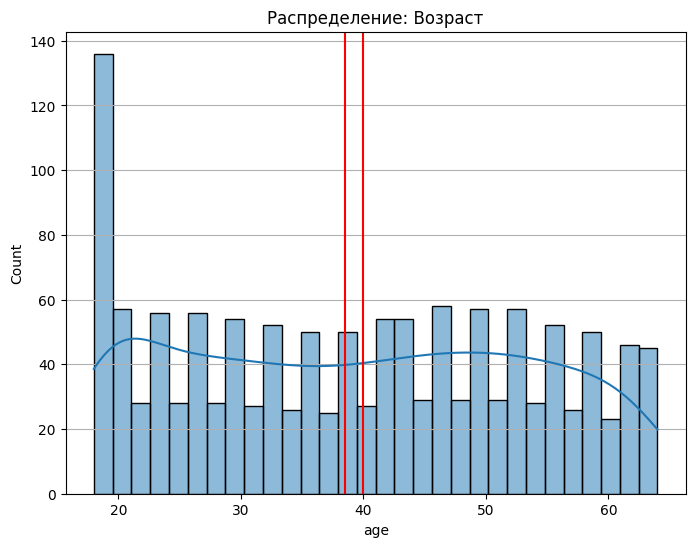

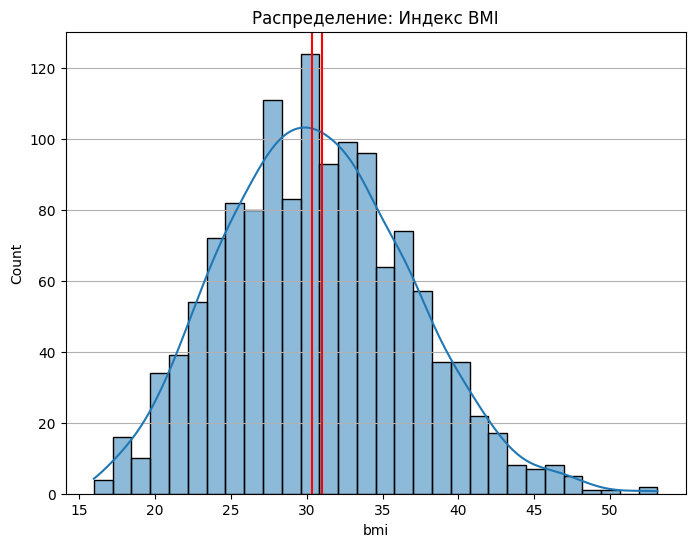

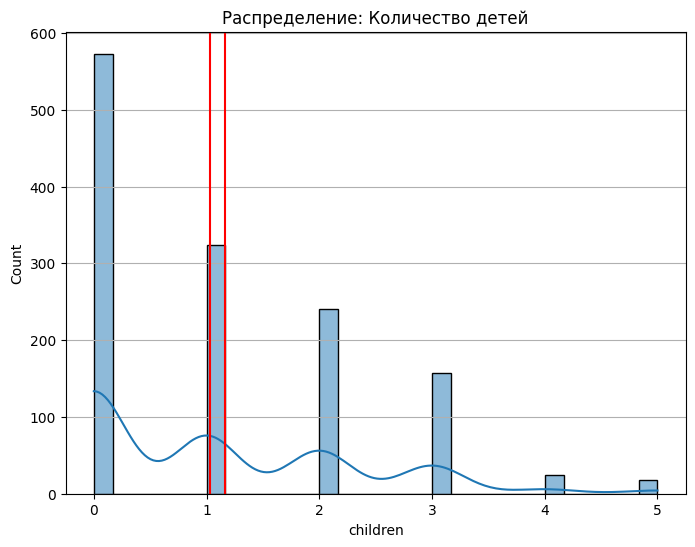

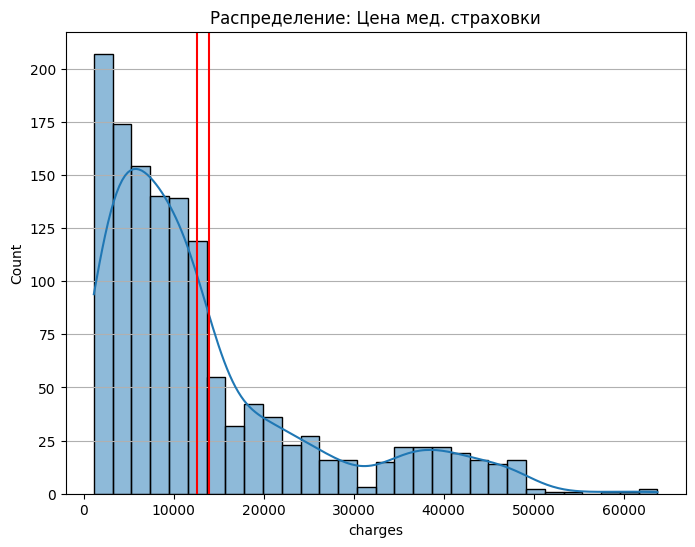

In [9]:
for feature, feature_name in num_features.items():
    sns.histplot(data=df, x=feature, kde=True, bins=30)
    plt.title(f'Распределение: {feature_name}')
    # Границы доверительного интервала
    plt.axvline(x=confidence_interval(feature)[0], color='red')
    plt.axvline(x=confidence_interval(feature)[1], color='red')
    plt.grid(axis='y')
    plt.show()

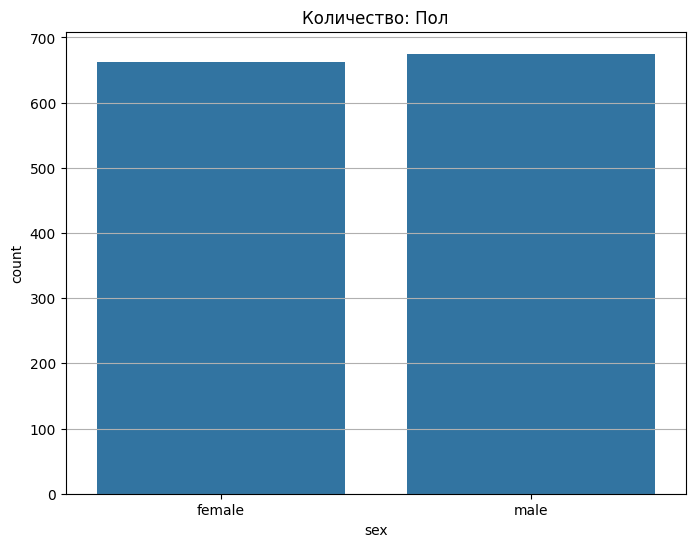

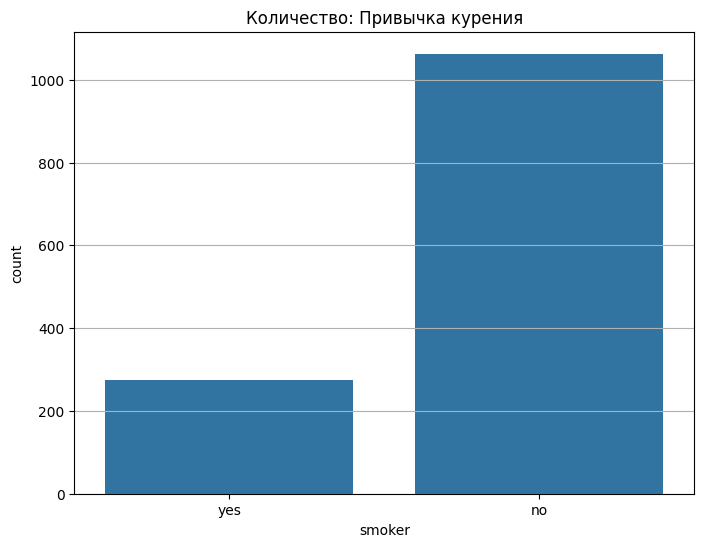

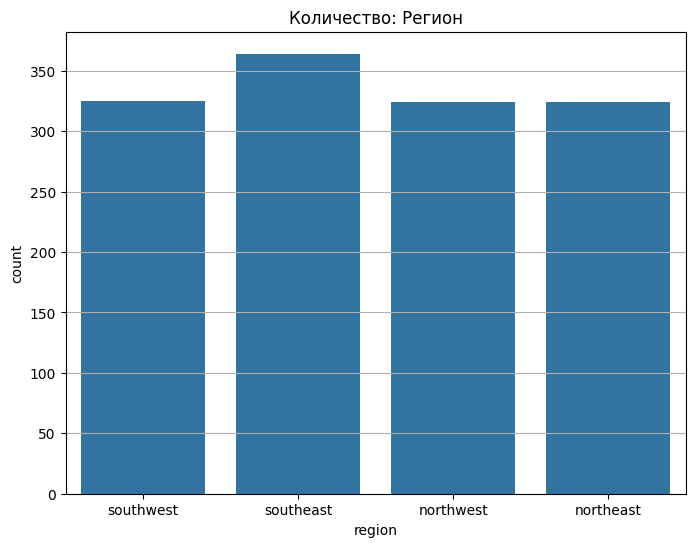

In [10]:
for feature, feature_name in cat_features.items():
    sns.countplot(x=df[feature])
    plt.title(f'Количество: {feature_name}')
    plt.grid(axis='y')
    plt.show()

In [11]:
genders = pd.DataFrame(df['sex'].value_counts())
genders['percentage'] = (genders['count'] / len(df) * 100).round(2)
genders

,count,percentage
sex,,
male,675,50.49
female,662,49.51


## Числовые признаки
### Возраст
- Распределение относительно равномерное во всех возрастах от 20 до 60 лет.
- Выраженный пик на значении 18 лет (возможно, особенность датасета).

### Индекс BMI
- Распределение близко к нормальному с центром около 30 единиц (граница избыточного веса).
- Наблюдается лёгкая асимметрия вправо (правый хвост - значения выше 40–45).

### Количество детей
- Большинство респондентов не имеют детей.
- Среднее кол-во детей у респондентов - 1. Редко встречаются известные данные о 4 и более детях.

### Цена медицинской страховки **(целевой признак)**
-Большинство клиентов платят до 15 000 у.е., но есть выбросы свыше 60 000.
- Вероятно, выбросы связаны с возрастом.

## Категориальные признаки
### Пол
- Распределение мужчин и женщин почти идеально сбалансировано (мужчин - 675, женщин - 662, 50.5% и 49.5% соответственно).

### Привычка курения
- Большинство клиентов — некурящие (~80%).
- Курильщиков заметно меньше, но **они могут оказывать сильное влияние на стоимость страховки**.

In [12]:
df['sex'] = df['sex'].map({
    'male': 0,
    'female': 1
})
df['smoker'] = df['smoker'].map({
    'yes': 1,
    'no': 0
})

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


In [13]:
cat_features.items()

dict_items([('sex', 'Пол'), ('smoker', 'Привычка курения'), ('region', 'Регион')])

In [14]:
# Проверка значимости бинарных признаков (курение, пол)
for feature, name_features in list(cat_features.items())[:-1]: # Кроме последнего НЕбинарного признака - регион
    sample_true = df[df[feature] == 1]['charges']
    sample_false = df[df[feature] == 0]['charges']
    
    mean_true = sample_true.mean()
    mean_false = sample_false.mean()
    
    t, p = ttest_ind(sample_true, sample_false, equal_var=False)
    print(f'{name_features}: потенциально {"ВЛИЯЕТ" if p <.05 else "НЕ ВЛИЯЕТ"} на цену мед. страховки; p-value={p:.4f}')

Пол: потенциально ВЛИЯЕТ на цену мед. страховки; p-value=0.0336
Привычка курения: потенциально ВЛИЯЕТ на цену мед. страховки; p-value=0.0000


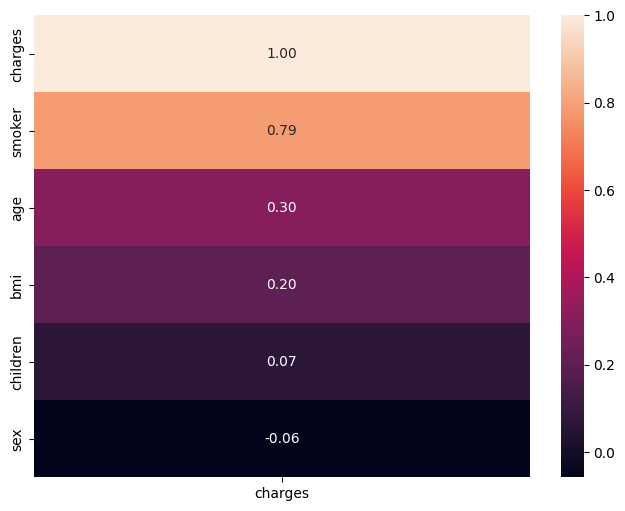

,charges
charges,1.000000
smoker,0.787234
age,0.298308
bmi,0.198401
children,0.067389
sex,-0.058044


In [15]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr[['charges']].sort_values(by='charges', ascending=False), annot=True, fmt='.2f')
plt.show()
display(pd.DataFrame(df_corr['charges'].sort_values(ascending=False)))

> На основе коэффициента корреляции Пирсона была изучена связь признаков со стоимостью медицинской страховки.
---
<u>1. Наиболее значимый фактор: `smoker` = *0.79*</u>

- Курение - ключевой фактор риска и один из главных драйверов роста страховых выплат. Этот признак критически важен для моделей предсказания.

<u>2. age (r = 0.30)</u>
- Возраст имеет умеренную положительную корреляцию с ценой страховки.
- С увеличением возраста растёт вероятность хронических заболеваний и медицинских вмешательств.

<u>3. bmi (r = 0.20)</u>
- Индекс массы тела слабо, но устойчиво связан с ростом стоимости страховки.
- Повышенный BMI может быть индикатором дополнительных рисков для здоровья.

---

> Стоимость медицинской страховки в первую очередь определяется поведенческими (курение) и демографическими (возраст) факторами.

## Проверка гипотез

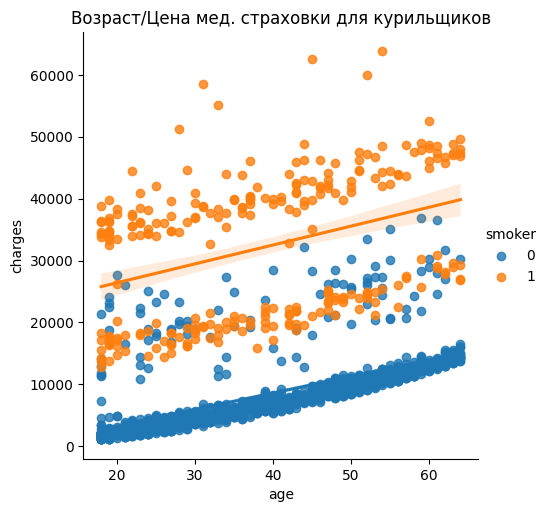

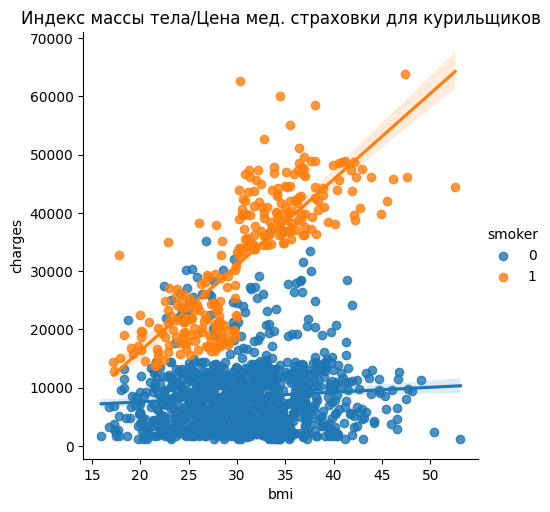

In [16]:
sns.lmplot(data=df, x='age', y='charges', hue='smoker')
plt.title('Возраст/Цена мед. страховки для курильщиков')
plt.show()

sns.lmplot(data=df, x='bmi', y='charges', hue='smoker')
plt.title('Индекс массы тела/Цена мед. страховки для курильщиков')
plt.show()

> Курение усиливает влияние возраста и BMI на стоимость страховки, что указывает на нелинейные зависимости и взаимодействия признаков.

# Подготовка признаков 

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer

In [18]:
df['charges_log'] = np.log1p(df['charges']) # Лог-преобразование целевой переменной для снижения чувствительности к выбросам.

In [19]:
X = df.drop(columns=['charges', 'charges_log'])
y = df['charges_log']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [21]:
X_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [22]:
if X_train.columns.all() == X_test.columns.all():
    print(X_train.dtypes)

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region       object
dtype: object


In [23]:
num_features = ['age', 'bmi', 'children', 'sex', 'smoker']
cat_features = ['region']

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

# Моделирование

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [26]:
# Все модели для использования и гиперпараметры для подбора.

models_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'param_grid': {}
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'param_grid': {'model__alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=10000),
        'param_grid': {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=10000),
        'param_grid': {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__l1_ratio': [0.1, 0.5, 0.9]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance']}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 5, 10]}
    },
    'XGBRegressor': {
        'model': XGBRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__subsample': [0.8, 1.0]
        }
    }
}

In [27]:
def fit_model(model_name, X_train=X_train, y_train=y_train, preprocessor=preprocessor, scoring='neg_mean_squared_error'):
    """
    Функция для быстрого обучения конкретной модели, просмотра метрик.
    Возвращает модель с самыми оптимальными гиперпараметрами по метрике MAE.
    """
    model_info = models_grids[model_name]
    model = model_info['model']
    param_grid = model_info['param_grid']
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"ОБУЧЕННАЯ МОДЕЛЬ: {model_name}")
    print(f'Результат по {scoring}: {-grid_search.best_score_:.4f}')
    display(grid_search.best_estimator_)
    
    return grid_search.best_estimator_

In [28]:
best_lr = fit_model('LinearRegression')
best_ridge = fit_model('Ridge')
best_lasso = fit_model('Lasso')
best_en = fit_model('ElasticNet')
best_knn = fit_model('KNN')
best_rf = fit_model('RandomForest')
best_xgbc = fit_model('XGBRegressor')

ОБУЧЕННАЯ МОДЕЛЬ: LinearRegression
Результат по neg_mean_squared_error: 0.2086


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model', LinearRegression())])

ОБУЧЕННАЯ МОДЕЛЬ: Ridge
Результат по neg_mean_squared_error: 0.2086


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model', Ridge(alpha=10, random_state=42))])

ОБУЧЕННАЯ МОДЕЛЬ: Lasso
Результат по neg_mean_squared_error: 0.2087


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model', Lasso(alpha=0.001, max_iter=10000, random_state=42))])

ОБУЧЕННАЯ МОДЕЛЬ: ElasticNet
Результат по neg_mean_squared_error: 0.2086


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000,
                            random_state=42))])

ОБУЧЕННАЯ МОДЕЛЬ: KNN
Результат по neg_mean_squared_error: 0.1759


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model', KNeighborsRegressor(n_neighbors=9))])

ОБУЧЕННАЯ МОДЕЛЬ: RandomForest
Результат по neg_mean_squared_error: 0.1537


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1,
                                       random_state=42))])

ОБУЧЕННАЯ МОДЕЛЬ: XGBRegressor
Результат по neg_mean_squared_error: 0.1473


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              ea...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, ...))])

## XGBRegressor

- Лучшая модель по результатам на кросс-валидации.
`MSE = 0.1473`

In [29]:
model = best_xgbc

print('Лучшая модель:')
display(model)

Лучшая модель:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex', 'smoker']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              ea...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [30]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('MAE', mae)
print('RMSE', rmse)
print('R^2', r2)

MAE 0.18416492811875546
RMSE 0.328457866642107
R^2 0.8837310324968166


# Результаты XGBRegressor
---
### MAE ≈ 0.18
- Средняя ошибка предсказания в лог-пространстве: ~18%.
    - ошибка ±18–20% от реальной стоимости страховки

### RMSE ≈ 0.33
    - RMSE чувствительнее к большим ошибкам, чем MAE.
    - модель не систематически промахивается на экстремальных значениях

## Коэффициент детерминации R²: 0.884
    - модель объясняет ~88% дисперсии стоимости страховки

    - оставшиеся ~12% - шум, индивидуальные медицинские случаи, неучтённые факторы

---
Обученная модель градиентного бустинга считается удовлетворительной для использования.

---
### <span style='color: orange'>При проверке результатов **необходмио** переводить предсказанное значение в номинальное из logit-преобразования:</span>
```python
nomial_result = np.expm1(logit_result)
```

In [31]:
y_pred_nomial = np.expm1(y_pred)

print(f'Предсказанные logit-цены: {y_pred[:5]}')
print(f'Предсказанные цены (номинал): {y_pred_nomial[:5]}')

Предсказанные logit-цены: [ 9.204187  8.770808  9.383718 10.56229   8.620132]
Предсказанные цены (номинал): [ 9937.659   6442.378  11892.1455 38648.543   5541.1206]


## Влияние признаков

In [32]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['model'].feature_importances_

imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

imp_df.head(10)

,feature,importance
4,num__smoker,0.640614
0,num__age,0.190559
2,num__children,0.062636
1,num__bmi,0.030847
5,cat__region_northwest,0.027930
3,num__sex,0.019701
7,cat__region_southwest,0.014233
6,cat__region_southeast,0.013478


### Самые влиятельные признаки:

1. `smoker`
- Привычка курения является доминирующим фактором, определяющим стоимость медицинской страховки. Более 60% всей объясняемой моделью вариации приходится именно на этот признак.

> Курение существенно повышает ожидаемые медицинские расходы, что оправдывает более высокие страховые тарифы для курильщиков.

2. `age`
- Возраст оказывает значительное влияние на стоимость страховки. С увеличением возраста растёт вероятность хронических заболеваний и потребность в медицинских услугах.

3. `children`
- Количество детей имеет умеренное влияние. Наличие иждивенцев может увеличивать общие медицинские расходы семьи.

4. `bmi` 
- Индекс массы тела оказывает относительно слабое влияние по сравнению с курением и возрастом,
однако остаётся значимым индикатором риска для здоровья.

5. `sex`
- Пол застрахованного имеет минимальное влияние на стоимость страховки.

In [33]:
import joblib

model_path = 'models/xgbregressor_insurance_.joblib'

try:
    joblib.dump(model, model_path)
    print(f'Модель XGBRegressor сохранена в {model_path}')
except Exception as e:
    print(f'Не удалось сохранить модель XGBRegressor:\n{e}')

Модель XGBRegressor сохранена в models/xgbregressor_insurance_.joblib
